In [2]:
import os, glob, pickle, numpy as np, pandas as pd, pyedflib
from scipy.signal import butter, filtfilt, resample_poly, iirnotch
import matplotlib.pyplot as plt
from config.config import DataConfig

In [3]:
def notch_filter(data, fs, freq=60, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, data)

def lowpass_filter(data, fs, cutoff=90, order=4):
    nyq = fs/2.0
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def downsample_window(data, fs, target_fs=200):
    return resample_poly(data, target_fs, fs)

In [4]:
data_dir = DataConfig.BASE_PATH
print(data_dir)
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])
# subject_batch = subject_dirs[5:6]
subject_batch = subject_dirs[0:1]
# subject_batch = subject_dirs[1:2]
for subject in subject_batch:
    print("Subject folder:", subject)

/Users/kimberly/Documents/STAT4830/STAT-4830-GOALZ-project/Anphy Dataset
Subject folder: EPCTL06


BATCH 1

In [5]:
data_dir = DataConfig.BASE_PATH
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# Split 93 electrodes into 10 groups and select the first group.
electrode_indices = np.arange(93)
electrode_groups = np.array_split(electrode_indices, 10)
first_group = electrode_groups[0]

subject_batch = subject_dirs[0:1]
# subject_batch = subject_dirs[1:2]
# subject_batch = subject_dirs[2:3]
# subject_batch = subject_dirs[3:4]

k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
n_per_stage = k // 2
window_sec = 2   # window spans 2 sec (±1 sec)
half_window_sec = window_sec / 2

for subject in subject_batch:
    subj_path = os.path.join(data_dir, subject)
    print(subj_path)
    csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
    print(csv_files)
    edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
    if not csv_files or not edf_files:
        print(f"Skipping {subject}: missing CSV or EDF.")
        continue
    df = pd.read_csv(csv_files[0], index_col=0) # had to change to 1 because that is what it is on mine
    df_W = df[df["stage"]=="W"]
    df_N1 = df[df["stage"]=="N1"]
    df_N2 = df[df["stage"]=="N2"]
    df_N3 = df[df["stage"]=="N3"]
    df_R = df[df["stage"]=="R"]

    if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
        print(f"Skipping {subject}: not enough epochs for one stage.")
        continue
    # fixed random_state for reproducibility.
    sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

    reader = pyedflib.EdfReader(edf_files[0])
    fs = reader.getSampleFrequency(0)  # 1000 Hz
    total_samples = reader.getNSamples()[0]
    n_channels = reader.signals_in_file
    signals = [reader.readSignal(i) for i in range(n_channels)]
    channel_labels = reader.getSignalLabels()
    reader.close()

    subject_windows = {}
    # Process only electrodes in the first group.
    for i in first_group:
        if i >= len(channel_labels):
            continue
        ch_label = channel_labels[i]
        for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
            for j, t in enumerate(sample_times):
                start = int((t - half_window_sec) * fs)
                end = int((t + half_window_sec) * fs)
                if start < 0 or end > total_samples:
                    continue
                win = signals[i][start:end]
                win = notch_filter(win, fs, freq=60, Q=30)
                win = lowpass_filter(win, fs, cutoff=90, order=4)
                ds_win = downsample_window(win, fs, target_fs=200)
                key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
                # Save both the processed window and the center time index.
                subject_windows[key] = {"window": ds_win, "time_index": t}

    out_path = os.path.join(subj_path, "complete_extracted_windows_group1.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(subject_windows, f)
    print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 1) at {out_path}")

BATCH 2

In [6]:
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# Split 93 electrodes into 10 groups and select the first group.
electrode_indices = np.arange(93)
electrode_groups = np.array_split(electrode_indices, 10)
# first_group = electrode_groups[0]
second_group = electrode_groups[1]

subject_batch = subject_dirs[3:4] # sub 4 - done
# subject_batch = subject_dirs[4:5]
# subject_batch = subject_dirs[5:6]

k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
n_per_stage = k // 2
window_sec = 2   # window spans 2 sec (±1 sec)
half_window_sec = window_sec / 2

for subject in subject_batch:
    subj_path = os.path.join(data_dir, subject)
    print(subj_path)
    csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
    print(csv_files)
    edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
    if not csv_files or not edf_files:
        print(f"Skipping {subject}: missing CSV or EDF.")
        continue
    df = pd.read_csv(csv_files[0], index_col=0)
    df_W = df[df["stage"]=="W"]
    df_N1 = df[df["stage"]=="N1"]
    df_N2 = df[df["stage"]=="N2"]
    df_N3 = df[df["stage"]=="N3"]
    df_R = df[df["stage"]=="R"]
    
    if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
        print(f"Skipping {subject}: not enough epochs for one stage.")
        continue
    # fixed random_state for reproducibility.
    sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

    reader = pyedflib.EdfReader(edf_files[0])
    fs = reader.getSampleFrequency(0)  # 1000 Hz
    total_samples = reader.getNSamples()[0]
    n_channels = reader.signals_in_file
    signals = [reader.readSignal(i) for i in range(n_channels)]
    channel_labels = reader.getSignalLabels()
    reader.close()

    subject_windows = {}
    # Process only electrodes in the first group.
    for i in second_group:
        if i >= len(channel_labels):
            continue
        ch_label = channel_labels[i]
        for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
            for j, t in enumerate(sample_times):
                start = int((t - half_window_sec) * fs)
                end = int((t + half_window_sec) * fs)
                if start < 0 or end > total_samples:
                    continue
                win = signals[i][start:end]
                win = notch_filter(win, fs, freq=60, Q=30)
                win = lowpass_filter(win, fs, cutoff=90, order=4)
                ds_win = downsample_window(win, fs, target_fs=200)
                key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
                # Save both the processed window and the center time index.
                subject_windows[key] = {"window": ds_win, "time_index": t}

    out_path = os.path.join(subj_path, "complete_extracted_windows_group2.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(subject_windows, f)
    print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 2) at {out_path}")

BATCH 3

In [7]:
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# # Split 93 electrodes into 10 groups and select the first group.
# electrode_indices = np.arange(93)
# electrode_groups = np.array_split(electrode_indices, 10)
# # first_group = electrode_groups[0]
# group = electrode_groups[2]

# # subject_batch = subject_dirs[6:7] 
# # subject_batch = subject_dirs[7:8]
# # subject_batch = subject_dirs[8:9]

# k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[1], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     df_N2 = df[df["stage"]=="N2"]
#     df_N3 = df[df["stage"]=="N3"]
#     df_R = df[df["stage"]=="R"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # 1000 Hz
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     # Process only electrodes in the first group.
#     for i in group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 # Save both the processed window and the center time index.
#                 subject_windows[key] = {"window": ds_win, "time_index": t}

#     out_path = os.path.join(subj_path, "complete_extracted_windows_group3.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 3) at {out_path}")

BATCH 4

In [8]:
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# # Split 93 electrodes into 10 groups and select the first group.
# electrode_indices = np.arange(93)
# electrode_groups = np.array_split(electrode_indices, 10)
# # first_group = electrode_groups[0]
# group = electrode_groups[3]

# # subject_batch = subject_dirs[9:10] # done
# # subject_batch = subject_dirs[10:11]
# subject_batch = subject_dirs[11:12]

# k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[1], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     df_N2 = df[df["stage"]=="N2"]
#     df_N3 = df[df["stage"]=="N3"]
#     df_R = df[df["stage"]=="R"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     # fixed random_state for reproducibility.
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # 1000 Hz
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     for i in group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 # Save both the processed window and the center time index.
#                 subject_windows[key] = {"window": ds_win, "time_index": t}

#     out_path = os.path.join(subj_path, "complete_extracted_windows_group4.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 4) at {out_path}")

BATCH 5

In [9]:
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# # Split 93 electrodes into 10 groups and select the first group.
# electrode_indices = np.arange(93)
# electrode_groups = np.array_split(electrode_indices, 10)
# # first_group = electrode_groups[0]
# group = electrode_groups[4]

# # subject_batch = subject_dirs[12:13] # done
# # subject_batch = subject_dirs[13:14] # done 
# # subject_batch = subject_dirs[14:15] # done

# k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     df_N2 = df[df["stage"]=="N2"]
#     df_N3 = df[df["stage"]=="N3"]
#     df_R = df[df["stage"]=="R"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     # fixed random_state
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # 1000 Hz
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     for i in group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 # Save both the processed window and the center time index.
#                 subject_windows[key] = {"window": ds_win, "time_index": t}

#     out_path = os.path.join(subj_path, "complete_extracted_windows_group5.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 5) at {out_path}")

In [10]:
# subj_path = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/epctl01"  

# pkl_path = os.path.join(subj_path, "extracted_windows_group1.pkl")

# with open(pkl_path, "rb") as f:
#     windows_dict = pickle.load(f)

# print("Total number of windows saved:", len(windows_dict))
# print("\nSample entries:")
# for key in list(windows_dict.keys())[:5]:
#     data = windows_dict[key]
#     print(f"Key: {key}")
#     print("  Window shape:", data["window"].shape)
#     print("  Center time index:", data["time_index"])


BATCH 6

In [11]:
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# # Split 93 electrodes into 10 groups and select the first group.
# electrode_indices = np.arange(93)
# electrode_groups = np.array_split(electrode_indices, 10)
# # first_group = electrode_groups[0]
# group = electrode_groups[5]

# # subject_batch = subject_dirs[15:16] 
# # subject_batch = subject_dirs[16:17] # done
# # subject_batch = subject_dirs[17:18] # done

# k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[1], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     df_N2 = df[df["stage"]=="N2"]
#     df_N3 = df[df["stage"]=="N3"]
#     df_R = df[df["stage"]=="R"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     # fixed random_state
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # 1000 Hz
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     for i in group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 # Save both the processed window and the center time index.
#                 subject_windows[key] = {"window": ds_win, "time_index": t}

#     out_path = os.path.join(subj_path, "complete_extracted_windows_group6.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 6) at {out_path}")

In [12]:
# import os
# import glob

# # Specify the path to your directory
# subj_path = "Anphy Dataset/EPCTL06"  # Adjust the path if necessary

# # List all files in the directory
# try:
#     files = os.listdir(subj_path)
#     print("Files in directory:", files)
# except FileNotFoundError:
#     print(f"Error: The directory {subj_path} was not found.")

# # Check for CSV and EDF files
# csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
# edf_files = glob.glob(os.path.join(subj_path, "*.edf"))

# # Print the found files
# print("CSV files found:", csv_files)
# print("EDF files found:", edf_files)

# # Check if any files were found
# if not csv_files and not edf_files:
#     print(f"Skipping {subj_path}: missing CSV or EDF")
# else:
#     print(f"Found files in {subj_path}. Proceeding with processing.")

PLOTTING

In [13]:
# subj_path = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/epctl18"
# pkl_path = os.path.join(subj_path, "extracted_windows_group6.pkl")

# with open(pkl_path, "rb") as f:
#     windows_dict = pickle.load(f)

# # Print all keys to verify available electrodes
# all_keys = list(windows_dict.keys())
# print("All keys in pkl:", all_keys)

# # For example, search for keys containing "p1ref" (not "fp1ref")
# w_keys = [key for key in all_keys if "p1ref" in key.lower() and "_w_" in key.lower()]
# n1_keys = [key for key in all_keys if "p1ref" in key.lower() and "_n1_" in key.lower()]

# print("W keys for p1ref:", w_keys)
# print("N1 keys for p1ref:", n1_keys)

# if w_keys and n1_keys:
#     window_w = windows_dict[w_keys[0]]["window"]
#     window_n1 = windows_dict[n1_keys[0]]["window"]
    
#     plt.figure(figsize=(10, 5))
#     plt.plot(window_w, label="Wake (W)")
#     plt.plot(window_n1, label="N1")
#     plt.xlabel("Sample Index (at 200 Hz)")
#     plt.ylabel("Amplitude")
#     plt.title("2-second Windows for electrode P1Ref")
#     plt.legend()
#     plt.show()
# else:
#     print("Could not find both W and N1 windows for electrode P1Ref")

/Users/kimberly/Documents/STAT4830/STAT-4830-GOALZ-project/Anphy Dataset
Unique electrode labels: ['CZRef', 'F7Ref', 'F8Ref', 'FZRef', 'PZRef', 'SO1Ref', 'T3Ref', 'T4Ref', 'T5Ref', 'T6Ref']


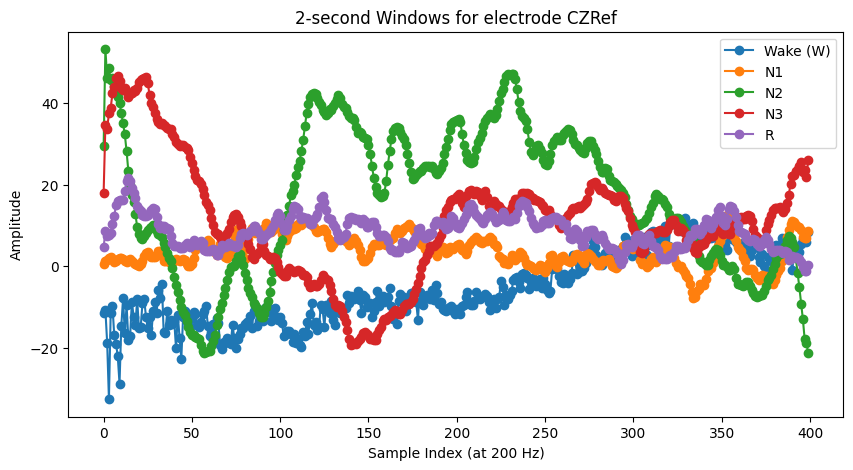

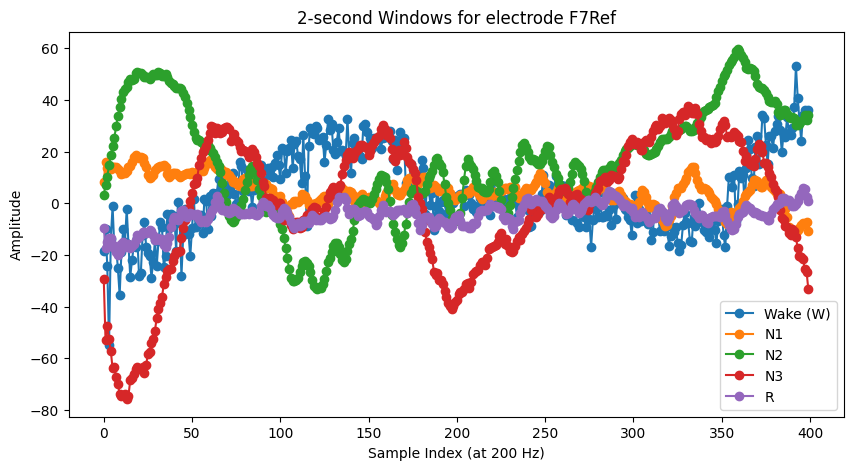

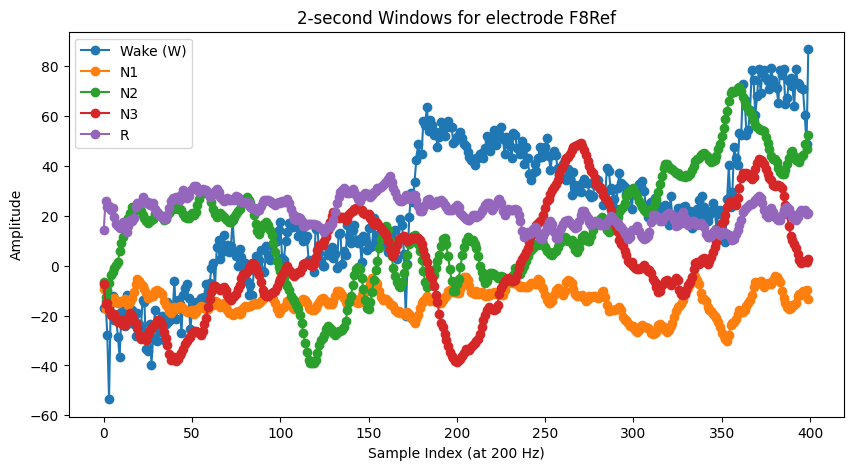

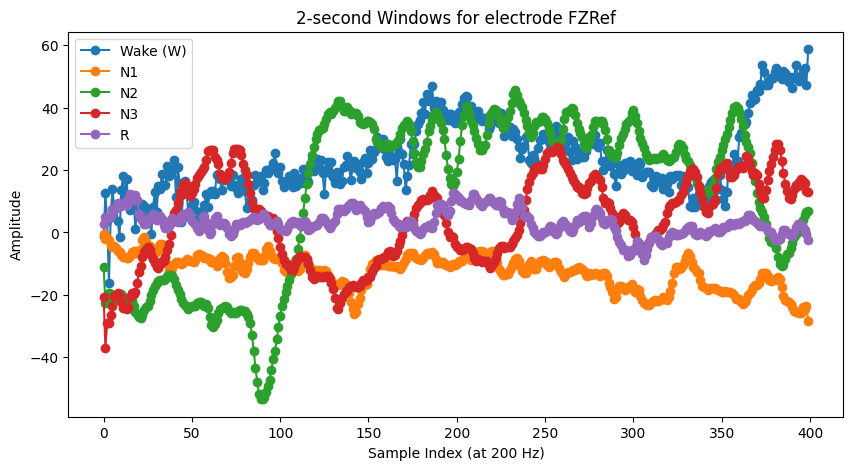

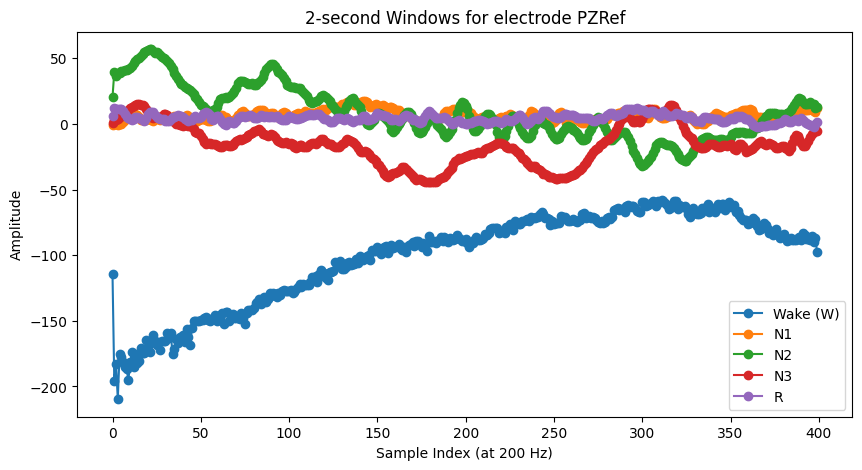

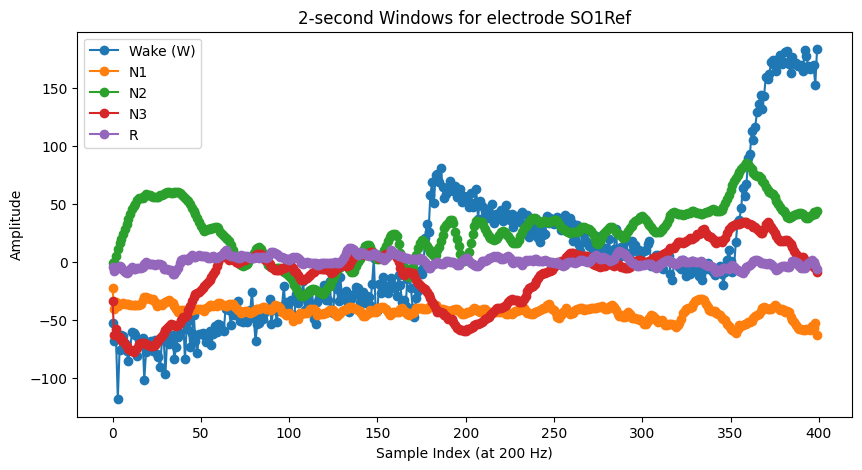

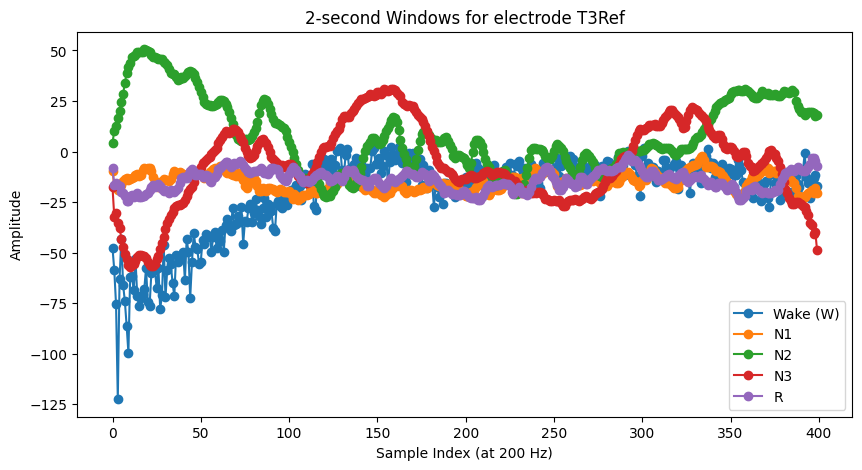

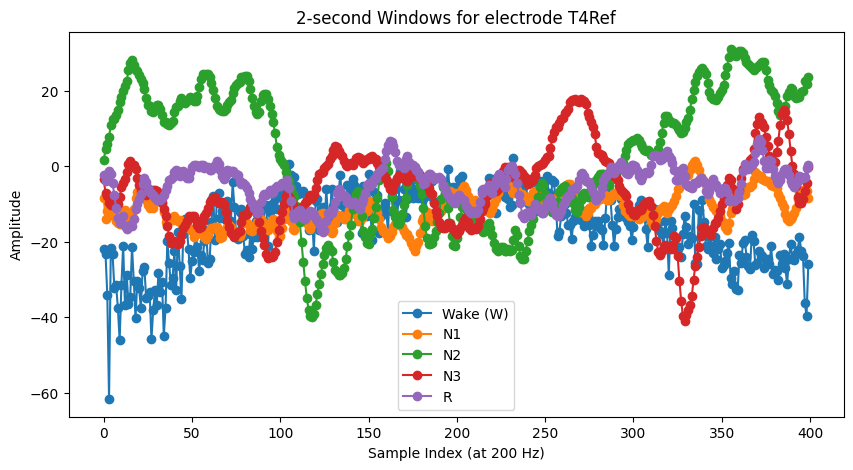

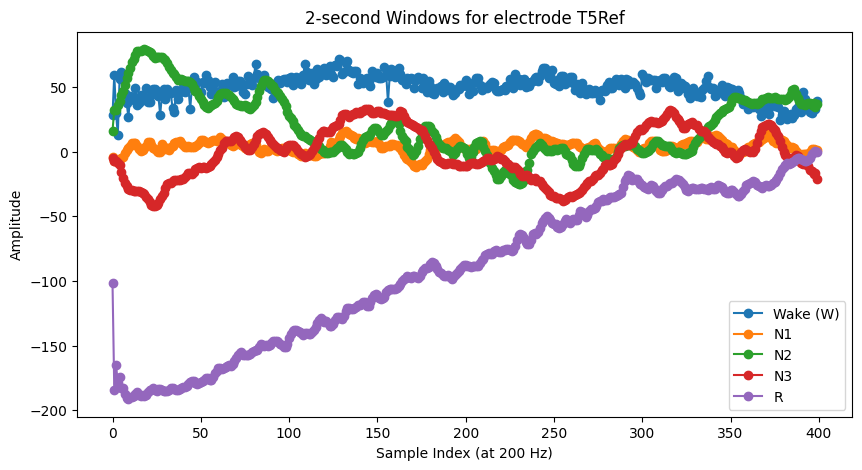

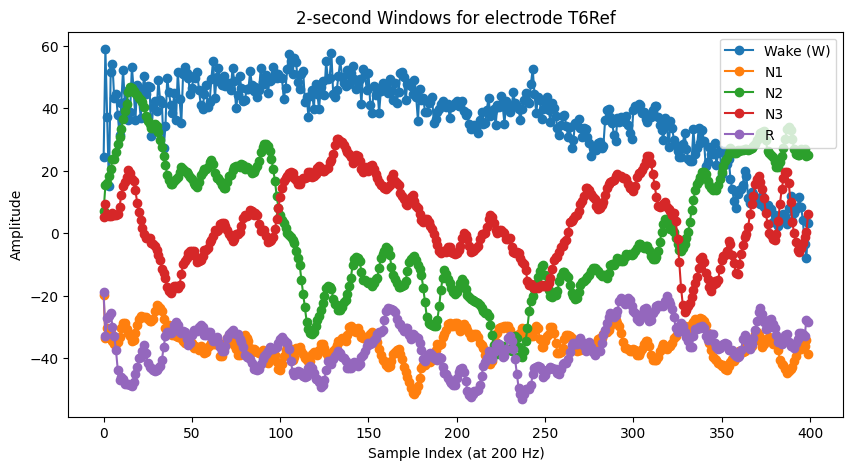

In [14]:
# base_path = DataConfig.BASE_PATH
# print(base_path)
# pkl_path = os.path.join(base_path, "/Users/kimberly/Documents/STAT4830/STAT-4830-GOALZ-project/Anphy Dataset/EPCTL06/complete_extracted_windows_group2.pkl")

# with open(pkl_path, "rb") as f:
#     windows_dict = pickle.load(f)

# # Get unique electrode labels from the keys.
# unique_electrodes = set()
# for key in windows_dict.keys():
#     # Assuming the electrode label is the last part of the key separated by underscores.
#     elec_label = key.split("_")[-1]
#     unique_electrodes.add(elec_label)

# unique_electrodes = sorted(unique_electrodes)
# print("Unique electrode labels:", unique_electrodes)

# # For each electrode, find the corresponding W and N1 keys and plot their windows.
# for elec in unique_electrodes:
#     # Find keys that contain the electrode label and stage.
#     w_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_w_" in k.lower()]
#     n1_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_n1_" in k.lower()]
#     n2_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_n2_" in k.lower()]
#     n3_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_n3_" in k.lower()]
#     r_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_r_" in k.lower()]

#         # Check if all keys are found
#     if w_keys and n1_keys and n2_keys and n3_keys and r_keys:
#         window_w = windows_dict[w_keys[0]]["window"]
#         window_n1 = windows_dict[n1_keys[0]]["window"]
#         window_n2 = windows_dict[n2_keys[0]]["window"]
#         window_n3 = windows_dict[n3_keys[0]]["window"]
#         window_r = windows_dict[r_keys[0]]["window"]

#         plt.figure(figsize=(10, 5))
#         plt.plot(window_w, marker='o', linestyle='-', label="Wake (W)")
#         plt.plot(window_n1, marker='o', linestyle='-', label="N1")
#         plt.plot(window_n2, marker='o', linestyle='-', label="N2")
#         plt.plot(window_n3, marker='o', linestyle='-', label="N3")
#         plt.plot(window_r, marker='o', linestyle='-', label="R")
#         plt.xlabel("Sample Index (at 200 Hz)")
#         plt.ylabel("Amplitude")
#         plt.title(f"2-second Windows for electrode {elec}")
#         plt.legend()
#         plt.show()
#     else:
#         print(f"Missing windows for electrode: {elec}")

In [15]:
# subj_path = "/Users/tereza/spring_2025/STAT_4830/STAT-4830-GOALZ-project/data/ANPHY-Sleep_data/epctl18"
# pkl_path = os.path.join(subj_path, "extracted_windows_group6.pkl")

# with open(pkl_path, "rb") as f:
#     windows_dict = pickle.load(f)

# # Collect unique electrode labels (last underscore-separated part of each key).
# unique_electrodes = set()
# for key in windows_dict.keys():
#     elec_label = key.split("_")[-1]
#     unique_electrodes.add(elec_label)

# unique_electrodes = sorted(unique_electrodes)

# for elec in unique_electrodes:
#     # Find the key for W
#     w_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_w_" in k.lower()]
#     # Find the key for N1
#     n1_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_n1_" in k.lower()]

#     n2_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_n2_" in k.lower()]

#     n3_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_n3_" in k.lower()]

#     r_keys = [k for k in windows_dict if elec.lower() in k.lower() and "_r_" in k.lower()]

#     if w_keys and n1_keys and n2_keys and n3_keys and r_keys:
#         w_key = w_keys[0]
#         n1_key = n1_keys[0]
#         n2_key = n2_keys[0]
#         n3_key = n3_keys[0]
#         r_key = r_keys[0]
#         w_time = windows_dict[w_key]["time_index"]
#         n1_time = windows_dict[n1_key]["time_index"]
#         n2_time = windows_dict[n2_key]["time_index"]
#         n3_time = windows_dict[n3_key]["time_index"]
#         r_time = windows_dict[r_key]["time_index"]
#         print(f"Electrode: {elec}")
#         print(f"  Wake clip centered at t={w_time:.2f} s (key: {w_key})")
#         print(f"  N1 clip centered at t={n1_time:.2f} s (key: {n1_key})")
        
#     else:
#         print(f"Electrode: {elec} has incomplete data (missing W or N1).")


BATCH 7

In [16]:
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# Split 93 electrodes into 10 groups and select the first group.
electrode_indices = np.arange(93)
electrode_groups = np.array_split(electrode_indices, 10)
# first_group = electrode_groups[0]
group = electrode_groups[6]

# subject_batch = subject_dirs[18:19] # 12:12 done
# subject_batch = subject_dirs[19:20] # done
subject_batch = subject_dirs[20:21] # done

k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
n_per_stage = k // 2
window_sec = 2   # window spans 2 sec (±1 sec)
half_window_sec = window_sec / 2

for subject in subject_batch:
    subj_path = os.path.join(data_dir, subject)
    csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
    edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
    if not csv_files or not edf_files:
        print(f"Skipping {subject}: missing CSV or EDF.")
        continue
    df = pd.read_csv(csv_files[0], index_col=0)
    df_W = df[df["stage"]=="W"]
    df_N1 = df[df["stage"]=="N1"]
    df_N2 = df[df["stage"]=="N2"]
    df_N3 = df[df["stage"]=="N3"]
    df_R = df[df["stage"]=="R"]
    if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
        print(f"Skipping {subject}: not enough epochs for one stage.")
        continue
    # fixed random_state
    sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

    reader = pyedflib.EdfReader(edf_files[0])
    fs = reader.getSampleFrequency(0)  # 1000 Hz
    total_samples = reader.getNSamples()[0]
    n_channels = reader.signals_in_file
    signals = [reader.readSignal(i) for i in range(n_channels)]
    channel_labels = reader.getSignalLabels()
    reader.close()

    subject_windows = {}
    for i in group:
        if i >= len(channel_labels):
            continue
        ch_label = channel_labels[i]
        for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
            for j, t in enumerate(sample_times):
                start = int((t - half_window_sec) * fs)
                end = int((t + half_window_sec) * fs)
                if start < 0 or end > total_samples:
                    continue
                win = signals[i][start:end]
                win = notch_filter(win, fs, freq=60, Q=30)
                win = lowpass_filter(win, fs, cutoff=90, order=4)
                ds_win = downsample_window(win, fs, target_fs=200)
                key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
                # Save both the processed window and the center time index.
                subject_windows[key] = {"window": ds_win, "time_index": t}

    out_path = os.path.join(subj_path, "complete_extracted_windows_group7.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(subject_windows, f)
    print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 7) at {out_path}")

KeyboardInterrupt: 

BATCH 8

In [16]:
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# Split 93 electrodes into 10 groups and select the first group.
electrode_indices = np.arange(93)
electrode_groups = np.array_split(electrode_indices, 10)
# first_group = electrode_groups[0]
group = electrode_groups[7]

subject_batch = subject_dirs[21:22] # done
# subject_batch = subject_dirs[22:23] # done
# subject_batch = subject_dirs[23:24] # done

k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
n_per_stage = k // 2
window_sec = 2   # window spans 2 sec (±1 sec)
half_window_sec = window_sec / 2

for subject in subject_batch:
    subj_path = os.path.join(data_dir, subject)
    csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
    edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
    if not csv_files or not edf_files:
        print(f"Skipping {subject}: missing CSV or EDF.")
        continue
    df = pd.read_csv(csv_files[0], index_col=0)
    df_W = df[df["stage"]=="W"]
    df_N1 = df[df["stage"]=="N1"]
    df_N2 = df[df["stage"]=="N2"]
    df_N3 = df[df["stage"]=="N3"]
    df_R = df[df["stage"]=="R"]
    if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
        print(f"Skipping {subject}: not enough epochs for one stage.")
        continue
    # fixed random_state
    sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

    reader = pyedflib.EdfReader(edf_files[0])
    fs = reader.getSampleFrequency(0)  # 1000 Hz
    total_samples = reader.getNSamples()[0]
    n_channels = reader.signals_in_file
    signals = [reader.readSignal(i) for i in range(n_channels)]
    channel_labels = reader.getSignalLabels()
    reader.close()

    subject_windows = {}
    for i in group:
        if i >= len(channel_labels):
            continue
        ch_label = channel_labels[i]
        for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1,  sample_N2, sample_N3, sample_R]):
            for j, t in enumerate(sample_times):
                start = int((t - half_window_sec) * fs)
                end = int((t + half_window_sec) * fs)
                if start < 0 or end > total_samples:
                    continue
                win = signals[i][start:end]
                win = notch_filter(win, fs, freq=60, Q=30)
                win = lowpass_filter(win, fs, cutoff=90, order=4)
                ds_win = downsample_window(win, fs, target_fs=200)
                key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
                # Save both the processed window and the center time index.
                subject_windows[key] = {"window": ds_win, "time_index": t}

    out_path = os.path.join(subj_path, "complete_extracted_windows_group8.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(subject_windows, f)
    print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 8) at {out_path}")

KeyboardInterrupt: 

BATCH 9

In [74]:
# subject_dirs = sorted([d for d in os.listdir(data_dir)
#                        if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# # Split 93 electrodes into 10 groups and select the first group.
# electrode_indices = np.arange(93)
# electrode_groups = np.array_split(electrode_indices, 10)
# group = electrode_groups[8]

# # subject_batch = subject_dirs[24:25] # done
# # subject_batch = subject_dirs[25:26] # done
# subject_batch = subject_dirs[26:27] # done

# k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
# n_per_stage = k // 2
# window_sec = 2   # window spans 2 sec (±1 sec)
# half_window_sec = window_sec / 2

# for subject in subject_batch:
#     subj_path = os.path.join(data_dir, subject)
#     csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
#     edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
#     if not csv_files or not edf_files:
#         print(f"Skipping {subject}: missing CSV or EDF.")
#         continue
#     df = pd.read_csv(csv_files[0], index_col=0)
#     df_W = df[df["stage"]=="W"]
#     df_N1 = df[df["stage"]=="N1"]
#     df_N2 = df[df["stage"]=="N2"]
#     df_N3 = df[df["stage"]=="N3"]
#     df_R = df[df["stage"]=="R"]
#     if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
#         print(f"Skipping {subject}: not enough epochs for one stage.")
#         continue
#     # fixed random_state
#     sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
#     sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values


#     reader = pyedflib.EdfReader(edf_files[0])
#     fs = reader.getSampleFrequency(0)  # 1000 Hz
#     total_samples = reader.getNSamples()[0]
#     n_channels = reader.signals_in_file
#     signals = [reader.readSignal(i) for i in range(n_channels)]
#     channel_labels = reader.getSignalLabels()
#     reader.close()

#     subject_windows = {}
#     for i in group:
#         if i >= len(channel_labels):
#             continue
#         ch_label = channel_labels[i]
#         for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
#             for j, t in enumerate(sample_times):
#                 start = int((t - half_window_sec) * fs)
#                 end = int((t + half_window_sec) * fs)
#                 if start < 0 or end > total_samples:
#                     continue
#                 win = signals[i][start:end]
#                 win = notch_filter(win, fs, freq=60, Q=30)
#                 win = lowpass_filter(win, fs, cutoff=90, order=4)
#                 ds_win = downsample_window(win, fs, target_fs=200)
#                 key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
#                 # Save both the processed window and the center time index.
#                 subject_windows[key] = {"window": ds_win, "time_index": t}

#     out_path = os.path.join(subj_path, "complete_extracted_windows_group9.pkl")
#     with open(out_path, "wb") as f:
#         pickle.dump(subject_windows, f)
#     print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 9) at {out_path}")

BATCH 10

In [1]:
data_dir = DataConfig.BASE_PATH
subject_dirs = sorted([d for d in os.listdir(data_dir)
                       if d.lower().startswith("epctl") and os.path.isdir(os.path.join(data_dir, d))])

# Split 93 electrodes into 10 groups and select the first group.
electrode_indices = np.arange(93)
electrode_groups = np.array_split(electrode_indices, 10)
group = electrode_groups[9]

# subject_batch = subject_dirs[27:28] 
subject_batch = subject_dirs[28:29] # last one!

k = 2  # windows per electrode per subject (so k/2 for "W" and k/2 for "N1")
n_per_stage = k // 2
window_sec = 2   # window spans 2 sec (±1 sec)
half_window_sec = window_sec / 2

for subject in subject_batch:
    subj_path = os.path.join(data_dir, subject)
    csv_files = glob.glob(os.path.join(subj_path, "*.csv"))
    edf_files = glob.glob(os.path.join(subj_path, "*.edf"))
    if not csv_files or not edf_files:
        print(f"Skipping {subject}: missing CSV or EDF.")
        continue
    df = pd.read_csv(csv_files[1], index_col=0)
    df_W = df[df["stage"]=="W"]
    df_N1 = df[df["stage"]=="N1"]
    df_N2 = df[df["stage"]=="N2"]
    df_N3 = df[df["stage"]=="N3"]
    df_R = df[df["stage"]=="R"]
    if len(df_W) < n_per_stage or len(df_N1) < n_per_stage:
        print(f"Skipping {subject}: not enough epochs for one stage.")
        continue
    # fixed random_state
    sample_W = df_W.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N1 = df_N1.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N2 = df_N2.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_N3 = df_N3.sample(n=n_per_stage, random_state=0)["time_index"].values
    sample_R = df_R.sample(n=n_per_stage, random_state=0)["time_index"].values

    reader = pyedflib.EdfReader(edf_files[0])
    fs = reader.getSampleFrequency(0)  # 1000 Hz
    total_samples = reader.getNSamples()[0]
    n_channels = reader.signals_in_file
    signals = [reader.readSignal(i) for i in range(n_channels)]
    channel_labels = reader.getSignalLabels()
    reader.close()

    subject_windows = {}
    for i in group:
        if i >= len(channel_labels):
            continue
        ch_label = channel_labels[i]
        for stage, sample_times in zip(["W", "N1", "N2", "N3", "R"], [sample_W, sample_N1, sample_N2, sample_N3, sample_R]):
            for j, t in enumerate(sample_times):
                start = int((t - half_window_sec) * fs)
                end = int((t + half_window_sec) * fs)
                if start < 0 or end > total_samples:
                    continue
                win = signals[i][start:end]
                win = notch_filter(win, fs, freq=60, Q=30)
                win = lowpass_filter(win, fs, cutoff=90, order=4)
                ds_win = downsample_window(win, fs, target_fs=200)
                key = f"{subject.lower()}_{stage.lower()}_win_{j+1}_{ch_label.replace('-', '').replace(' ', '')}"
                # Save both the processed window and the center time index.
                subject_windows[key] = {"window": ds_win, "time_index": t}

    out_path = os.path.join(subj_path, "complete_extracted_windows_group10.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(subject_windows, f)
    print(f"Saved {len(subject_windows)} windows for {subject} (electrode group 10) at {out_path}")

NameError: name 'DataConfig' is not defined